Variance-Bias Trade-off

To minimise the MSE we need to select a model that achieves low variance
and bias. The MSE can never be below Var(ϵ|X) because Var(f(X)|X) and
Bias(f(X)|X)^2 will always be positive.

As flexibility increases, variance will increase and bias will decrease. The
relative change of the quantities determines whether the test MSE will
decrease or increase

At some point increasing flexibility has little impact on bias but starts to
significantly increase variance and thus the test MSE increases (=overfit).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


This code generates a DataFrame data with x values from 0 to
4π and y values that follow a noisy sine wave pattern with an increasing variance as x increases.

In [ ]:
#Simulating Data

np.random.seed(234)
n = 150
grid = np.linspace(0, 4 * np.pi, n)
data = pd.DataFrame({
          'x': grid,
          'y': np.sin(grid) + np.sqrt(grid) * np.random.normal(0, 0.5, n)
          })



In [ ]:
#Splitting into Training and test data, chosen randomly, half of total rows. 2-fold

train = data.sample(n=n//2)
test = data.drop(train.index)


#Fit splines and compute MSE
Splines are a form of mathematical modeling often used to fit smooth, flexible curves through data points. They’re particularly useful for capturing non-linear relationships between variables without overfitting or creating a rigid, global polynomial that can oscillate wildly between data points.

allow us to model non-linear patterns in a controlled way, capturing the trend in the data while avoiding excessive oscillation.


In [ ]:

k_vals = [1, 2, 3, 4, 8, 16, 32]
r = np.arange(len(k_vals))
#creates an array r containing sequential integers from 0 to len(k_vals) - 1, which will be [0, 1, 2, 3, 4, 5, 6]

In [ ]:
#Define basis functions
from patsy import dmatrix

#Model of k degree polynomial and input data x.
def px(k, x):
  match k:
    case 1: return dmatrix("x") #Linear
    case 2: return dmatrix("x + x2", { "x2": x**2 })  # Quadratic
    case _: return dmatrix("bs(x, df={})".format(k)) #B-spline basis with the specified degrees of freedom (k). This allows for flexible, non-linear fits that can capture more complex patterns in the data.


In [ ]:
#Fit splines and compute MSE

#Initializing Empty Lists
mse_train, mse_test, yhats = [], [], []

#Looping over k_vals
for k in k_vals:
  fit = np.linalg.lstsq(px(k, train.x), train.y)[0] # solves for the least squares fit of the linear model using the generated basis matrix and the target variable train.y, [0] at the end extracts the fit coefficients

  yhat = np.dot(px(k, data.x), fit) # Creates ull array of predicted y values for all points in the dataset (data.x), not just the training set. To compare then to.

  # Calculating MSE for Training and Test Sets
  mse_train.append(np.mean((train.y - yhat[train.index]) ** 2))
  mse_test.append(np.mean((test.y - yhat[test.index]) ** 2))
  yhats.append(yhat)

<ipython-input-7-2ab072517d46>:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit = np.linalg.lstsq(px(k, train.x), train.y)[0] # solves for the least squares fit of the linear model using the generated basis matrix and the target variable train.y, [0] at the end extracts the fit coefficients
<ipython-input-7-2ab072517d46>:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit = np.linalg.lstsq(px(k, train.x), train.y)[0] # solves for the least squares fit of the linear model using the generated basis matrix and the ta

yhats

px(k, data.x) creates the basis matrix for the entire dataset (data.x) for the same k used in the current iteration.

np.dot(...) then calculates the predicted y values (yhat) for each x in data by applying the basis matrix to fit.


In [ ]:
print(data.head())  # Check the first few rows
print(data.columns)  # Check the column names

          x         y
0  0.000000  0.000000
1  0.084338 -0.067291
2  0.168676  0.239935
3  0.253014  0.482103
4  0.337352  0.305613
Index(['x', 'y'], dtype='object')


In [ ]:
# Creating New Data Frame for Predictions, organizing predicted y for each spline complexity.
preds = pd.DataFrame(np.column_stack(yhats), columns=k_vals) #Stacking as columns

# Assigning x and y values from original data in order to compare originals with predictions side by side.
preds['x'] = data['x']
preds['y'] = data['y']



preds['test'] = preds.index.isin(test.index)


#Reviewing
from google.colab import files
file_name1 = 'preds_data.xlsx'
data.to_excel(file_name1)
files.download(file_name1)





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

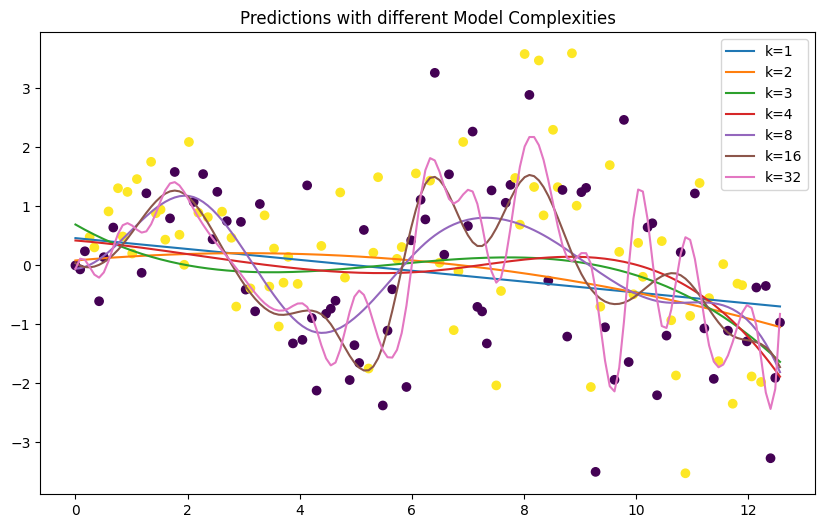

In [ ]:
#Scatter plot: The data points will be shown as scatter points, with color indicating whether the points are from the training or test set.
# Curves Each curve corresponds to a different k value (spline complexity), and the curves will be shown on top of the original data.

plt.figure(figsize = (10, 6))
plt.scatter(preds['x'], preds['y'], c=preds['test'])

for col in preds.columns.difference(['x', 'y', 'test']):
  plt.plot(preds['x'], preds[col], label=f'k={col}')


plt.title('Predictions with different Model Complexities')
plt.legend()
plt.show()

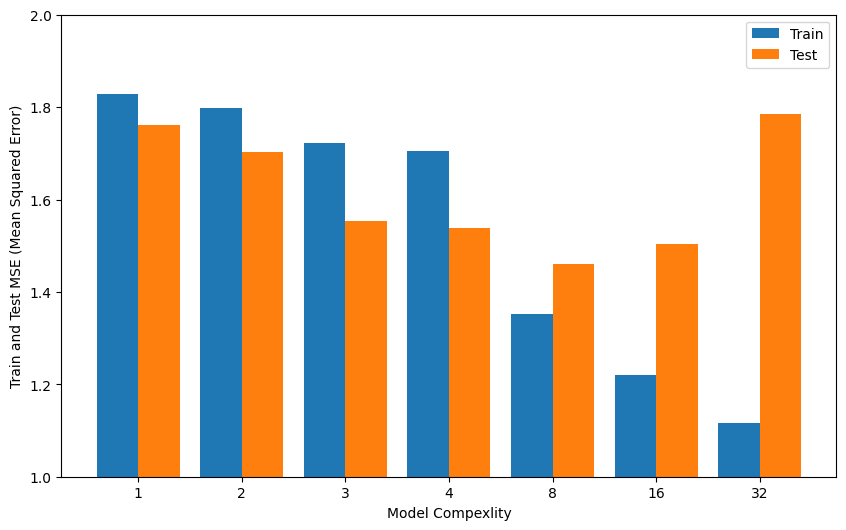

[1.829081830245243, 1.7991426741042793, 1.7219907975051645, 1.7042169434260734, 1.3518841546191107, 1.2194359482780202, 1.1167900631230179]
[1.760716002457624, 1.701957274685817, 1.5531691217583488, 1.5377029288397608, 1.4611978908394023, 1.50270873585651, 1.785664830730955]


In [ ]:
plt.figure(figsize = (10, 6))
plt.bar(r - 0.2, mse_train, width = 0.4, color = '#1f77b4', label='Train')
plt.bar(r + 0.2, mse_test, width = 0.4, color = '#ff7f0e', label='Test')

plt.xlabel('Model Compexlity')
plt.ylabel('Train and Test MSE (Mean Squared Error)')
plt.xticks(r, k_vals)
plt.ylim(1,2)
plt.legend()
plt.show()

print(mse_train)
print(mse_test)

Training MSE decreases as flexiblity increases, model can better fit the data

BUT

Test MSE starts increasing after 8 degree, so more flexible start yielding higher test MSE - starts to overfit.